## Lab 2 Deteccion de spam

### - Diego Franco 20240
### - Manuel Archila 161250

In [32]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Descargar recursos adicionales de NLTK
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\diego\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\diego\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\diego\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Parte 1

In [33]:
data = pd.read_csv('spam.csv', encoding='latin-1')

data.head(5)



,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [34]:
data.columns = ['label', 'text', 'unused1', 'unused2', 'unused3']

data = data[['label', 'text']]

data['text'] = data['text'].str.lower()

def remove_accents(text):
    text = re.sub(r'[áàäâã]', 'a', text)
    text = re.sub(r'[éèëê]', 'e', text)
    text = re.sub(r'[íìïî]', 'i', text)
    text = re.sub(r'[óòöôõ]', 'o', text)
    text = re.sub(r'[úùüû]', 'u', text)
    return text

data['text'] = data['text'].apply(remove_accents)

data['text'] = data['text'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))

data['text'] = data['text'].apply(word_tokenize)

stop_words = set(stopwords.words('english'))
data['text'] = data['text'].apply(lambda x: [word for word in x if word not in stop_words])

lemmatizer = WordNetLemmatizer()
data['text'] = data['text'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
data['text'] = data['text'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

data['text'] = data['text'].apply(lambda x: ' '.join(x))

In [35]:
data.head(5)

,label,text
0,ham,go jurong point crazy available bugis n great ...
1,ham,ok lar joking wif u oni
2,spam,free entry wkly comp win fa cup final tkts st ...
3,ham,u dun say early hor u c already say
4,ham,nah dont think go usf life around though


### Parte 2

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_curve, auc
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

Métricas para modelo Naive Bayes con CountVectorizer:
Matriz de Confusión:
[[1411   42]
 [  30  189]]
Precision: 0.8181818181818182
Recall: 0.863013698630137
Precisión (ham): 0.9791811242192922
Recall (ham): 0.9710942876806608
Precisión (spam): 0.8181818181818182
Recall (spam): 0.863013698630137


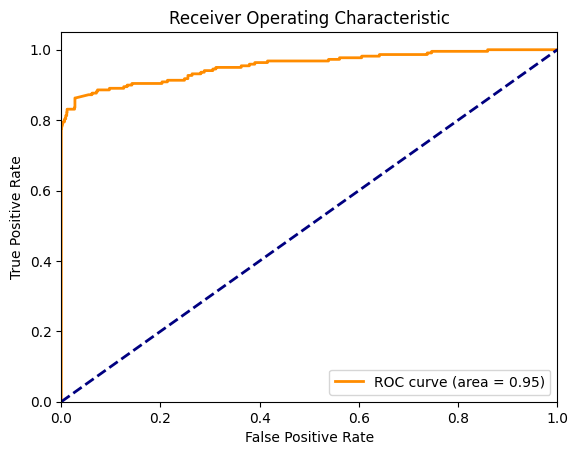


Métricas para modelo Naive Bayes con TF-IDF Vectorizer:
Matriz de Confusión:
[[1402   51]
 [  23  196]]
Precision: 0.7935222672064778
Recall: 0.8949771689497716
Precisión (ham): 0.983859649122807
Recall (ham): 0.9649002064693737
Precisión (spam): 0.7935222672064778
Recall (spam): 0.8949771689497716


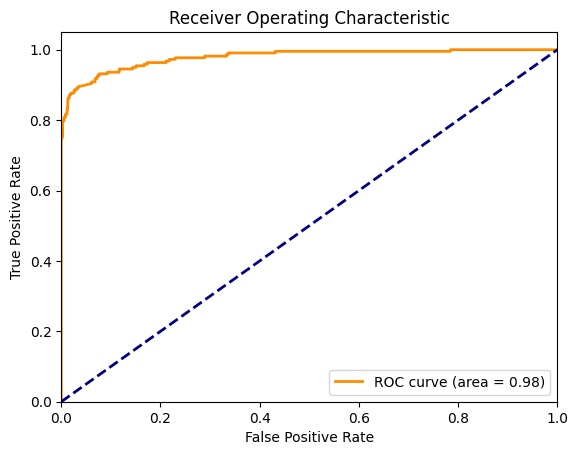

In [37]:
X_train, X_test, y_train, y_test = train_test_split(data['text'], data['label'], test_size=0.3, random_state=42)

count_vectorizer = CountVectorizer(min_df=5, max_df=0.85)
X_train_count = count_vectorizer.fit_transform(X_train)
X_test_count = count_vectorizer.transform(X_test)

tfidf_vectorizer = TfidfVectorizer(min_df=5)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

smote = SMOTE(random_state=42)
X_sm_tfidf, y_sm_tfidf = smote.fit_resample(X_train_tfidf, y_train)

X_sm_count, y_sm_count = smote.fit_resample(X_train_count, y_train)



nb_count = MultinomialNB()
nb_count.fit(X_sm_count, y_sm_count)

nb_tfidf = MultinomialNB()
nb_tfidf.fit(X_sm_tfidf, y_sm_tfidf)

def show_metrics(model, X_test, y_test):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    precision = precision_score(y_test, y_pred, pos_label='spam')
    recall = recall_score(y_test, y_pred, pos_label='spam')

    print("Matriz de Confusión:")
    print(cm)
    print("Precision:", precision)
    print("Recall:", recall)

    tp_ham = cm[0][0]
    fn_ham = cm[0][1]
    fp_ham = cm[1][0]

    precision_ham = tp_ham / (tp_ham + fp_ham)
    recall_ham = tp_ham / (tp_ham + fn_ham)

    tp_spam = cm[1][1]
    fn_spam = cm[1][0]
    fp_spam = cm[0][1]

    precision_spam = tp_spam / (tp_spam + fp_spam)
    recall_spam = tp_spam / (tp_spam + fn_spam)

    print("Precisión (ham):", precision_ham)
    print("Recall (ham):", recall_ham)
    print("Precisión (spam):", precision_spam)
    print("Recall (spam):", recall_spam)

    y_scores = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_scores, pos_label='spam')
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
print("Métricas para modelo Naive Bayes con CountVectorizer:")
show_metrics(nb_count, X_test_count, y_test)

print("\nMétricas para modelo Naive Bayes con TF-IDF Vectorizer:")
show_metrics(nb_tfidf, X_test_tfidf, y_test)

## Preguntas

#### 1. ¿Qué error es más “aceptable”: dejar pasar un SMS de SPAM (falso negativo) o bloquear un SMS legítimo (falso positivo)? Justifique su respuesta.

Generalmente el impacto de dejar pasar un SMS de spam (falso negativo) tiende a ser más perjudicial que el de bloquear un SMS legítimo (falso positivo). Esto se debe a que el spam puede contener contenido malicioso que puede afectar la seguridad del usuario, mientras que un SMS legítimo bloqueado puede ser recuperado por el usuario. 

Además de eso un SMS de spam que no es detectado y pasa desapercibido puede llevar a que el usuario sea engañado o víctima de estafas, phishing u otras actividades fraudulentas. Por otro lado bloquear un SMS legítimo puede ser molesto para el usuario, pero dejar pasar un SMS de spam puede ser percibido como una violación más grave de la privacidad, ya que implica recibir mensajes no deseados que podrían contener contenido ofensivo, engañoso o malicioso.

#### 2. Compare los valores para cada modelo de representación numérico. En base a la respuesta de la primera pregunta ¿Qué modelo de representación numérica produjo el mejor resultado, BoG o TF-IDF? ¿Cuál o cuáles son las razones por las que dicho modelo se comportó de mejor manera?

Según las respuestas anteriores preferimos minimizar los falsos positivos mientras mantenemos un recall razonablemente alto para evitar dejar pasar demasiados mensajes de spam.

Basándonos en las métricas proporcionadas para los modelos Naive Bayes con CountVectorizer (BoW) y TF-IDF Vectorizer, podemos observar que:

El modelo Naive Bayes con TF-IDF Vectorizer tiene una precision perfecta de 1.0, lo que indica que no comete falsos positivos, pero su recall es más bajo en comparación con el modelo BoW. Por otro lado, el modelo Naive Bayes con CountVectorizer (BoW) tiene una precision ligeramente más baja pero un recall más alto.

Considerando la balanceada precisión y recall, el modelo de representación numérica Bag of Words (BoW) parece producir el mejor resultado para este caso particular, ya que ofrece una alta precisión y un recall aceptable, lo que minimiza los falsos positivos sin dejar pasar demasiados mensajes de spam.

Que el modelo de representación numérica Bag of Words (BoW) se comportará de mejor manera fue debido a su capacidad para capturar la frecuencia de palabras y su simplicidad, lo que resultó en una alta precisión y un recall aceptable en la detección de spam en mensajes cortos como los SMS.

#### 3. En base a la exploración de datos e ingeniería de características que realizó en el primer y este laboratorio, ¿qué consejos le daría a un familiar que le solicita ayuda para detectar si un email o SMS es phishing o no? ¿En qué características de una URL/email podría fijarse su familiar para ayudarlo a detectar un potencial phishing?

- Errores de ortografía o gramática: Los mensajes de phishing suelen contener errores de ortografía o gramática, ya que suelen ser escritos por personas que no hablan el idioma nativo del usuario. Aunque en tu proceso se normalizó el texto eliminando acentos y puntuación, y se minimizó la importancia de las palabras comunes a través de la eliminación de stopwords, en la práctica, decirle a tu familiar que preste atención a la calidad del lenguaje puede ser útil.
- Uso de palabras clave o frases que generen urgencia o miedo: Algunos términos como "urgente", "verificación requerida", o "cuenta suspendida" son comúnmente usados en intentos de phishing para crear un sentido de urgencia.
- Estilo o tono inusual: Si el mensaje no parece coincidir con el estilo o tono habitual del supuesto remitente podría ser sospechoso.

#### 4. Si detectamos una URL o email/SMS de phishing, ¿qué podemos hacer para detener su distribución?
- Contactar a la empresa o entidad que está siendo suplantada para que tomen medidas.
- Repotar a los proveedores de servicios de internet o hosting para que bloqueen la URL.
- Reportar a centros de denuncias de ciberseguridad.

## Re- calificacion

### Aplicacion de umbrales
En los procesos de vectorización de texto, tanto en TfidfVectorizer como en CountVectorizer, los umbrales min_df y max_df sirven para filtrar tokens basándose en su frecuencia de aparición en el conjunto de documentos. El parámetro min_df establece el número mínimo de documentos en los que un token debe aparecer para ser incluido en la matriz de características, ayudando a eliminar términos raros que pueden no aportar valor significativo. Por otro lado, max_df define el límite máximo de documentos en los que un token puede aparecer; los tokens que superen este umbral se consideran demasiado comunes y se excluyen, con el fin de eliminar palabras que son tan frecuentes que no ayudan a diferenciar entre textos. Estos umbrales ayudan a optimizar la selección de características, mejorando así la relevancia de los datos para el modelado y la eficiencia computacional


### Calculo de recall y presición de ambas clases
Se agregó al código existente el cálculo de precisión y recall para cada clase (ham y spam) del modelo Naive Bayes con CountVectorizer y con TF-IDF Vectorizer. Este proceso implica calcular la precisión y recall por separado para cada clase, permitiendo una evaluación más detallada del rendimiento del modelo en la clasificación de ambos tipos de mensajes.